In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

# Load model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Enable hidden states
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
model = AutoModel.from_pretrained(model_name, config=config)

# Move model to device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
vars(model.config)

{'vocab_size': 50257,
 'n_positions': 1024,
 'n_embd': 768,
 'n_layer': 12,
 'n_head': 12,
 'n_inner': None,
 'activation_function': 'gelu_new',
 'resid_pdrop': 0.1,
 'embd_pdrop': 0.1,
 'attn_pdrop': 0.1,
 'layer_norm_epsilon': 1e-05,
 'initializer_range': 0.02,
 'summary_type': 'cls_index',
 'summary_use_proj': True,
 'summary_activation': None,
 'summary_first_dropout': 0.1,
 'summary_proj_to_labels': True,
 'scale_attn_weights': True,
 'use_cache': True,
 'scale_attn_by_inverse_layer_idx': False,
 'reorder_and_upcast_attn': False,
 'bos_token_id': 50256,
 'eos_token_id': 50256,
 'return_dict': True,
 'output_hidden_states': True,
 'output_attentions': False,
 'torchscript': False,
 'torch_dtype': None,
 'use_bfloat16': False,
 'tf_legacy_loss': False,
 'pruned_heads': {},
 'tie_word_embeddings': True,
 'chunk_size_feed_forward': 0,
 'is_encoder_decoder': False,
 'is_decoder': False,
 'cross_attention_hidden_size': None,
 'add_cross_attention': False,
 'tie_encoder_decoder': False,


In [ ]:
num_layers = model.config.num_hidden_layers
input_dim = model.config.hidden_size  # Input and hidden dims are the same for BERT
hidden_dim = model.config.hidden_size


print(f"Number of layers: {num_layers}")
print(f"Input dimension: {input_dim}")
print(f"Hidden dimension: {hidden_dim}")


Number of layers: 12
Input dimension: 768
Hidden dimension: 768


In [ ]:
def effective_rank(matrix):
    # Perform Singular Value Decomposition (SVD)
    U, S, V = torch.svd(matrix)

    # Normalize the singular values
    S_normalized = S / S.sum()

    # Compute the entropy of the normalized singular values
    entropy = -torch.sum(S_normalized * torch.log(S_normalized))

    # Compute the effective rank
    effective_rank = torch.exp(entropy).item()

    return effective_rank

# **Statistics across the entire head**

In [ ]:
# change counting_stats function for whatever desired


query_fraction = []
key_fraction = []
value_fraction = []

threshold = 10e-4

def counting_stats(weight_tensor, cutoff = threshold):
  """Counts entries in a weight tensor less than a given threshold."""
  return (torch.abs(weight_tensor) < cutoff).sum().item()

# Size of query / key / value matrix
attn_size_per_layer = input_dim * hidden_dim


for i in range(num_layers):
  all_weights = model.h[i].attn.c_attn.weight

  query_weights = all_weights[:, :hidden_dim]
  num_entries_less_than = counting_stats(query_weights, threshold)
  query_fraction.append(num_entries_less_than / attn_size_per_layer)

  key_weights = all_weights[:, hidden_dim:2*hidden_dim]
  num_entries_less_than = counting_stats(key_weights, threshold)
  key_fraction.append(num_entries_less_than / attn_size_per_layer)

  value_weights = all_weights[:, 2*hidden_dim:]
  num_entries_less_than = counting_stats(value_weights, threshold)
  value_fraction.append(num_entries_less_than / attn_size_per_layer)



print('Query:', query_fraction)
print('Key:', key_fraction)
print('Value:', value_fraction)



Query: [0.004092746310763889, 0.008889092339409722, 0.006103515625, 0.005132039388020833, 0.00531005859375, 0.005950927734375, 0.006574842664930556, 0.006232367621527778, 0.006339179144965278, 0.006724039713541667, 0.0069427490234375, 0.007273356119791667]
Key: [0.004292805989583333, 0.007363213433159722, 0.006868150499131944, 0.005408393012152778, 0.005610148111979167, 0.0062255859375, 0.006693522135416667, 0.006540934244791667, 0.006735907660590278, 0.006696912977430556, 0.007214016384548611, 0.007814195421006944]
Value: [0.015819973415798612, 0.009090847439236112, 0.009877522786458334, 0.009935167100694444, 0.009377373589409722, 0.008694118923611112, 0.007648044162326389, 0.007671780056423611, 0.007208930121527778, 0.006661309136284722, 0.006259494357638889, 0.005481296115451389]


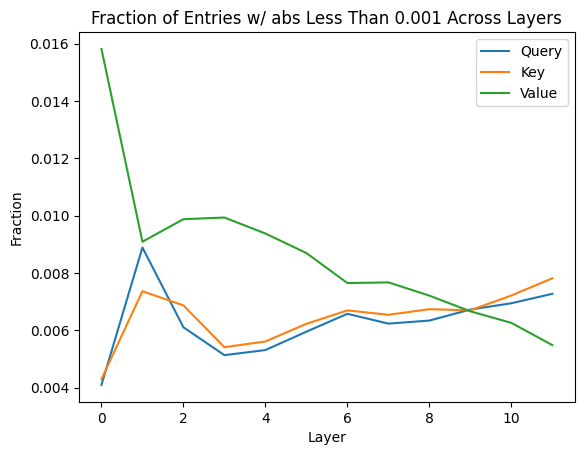

In [ ]:
import matplotlib.pyplot as plt

layers = range(num_layers)
# Plotting the lines
plt.plot(layers, query_fraction, label="Query")
plt.plot(layers, key_fraction, label="Key")
plt.plot(layers, value_fraction, label="Value")

# Adding labels and title
plt.xlabel("Layer")
plt.ylabel("Fraction")
plt.title(f"Fraction of Entries w/ abs Less Than {threshold} Across Layers")
plt.legend()

# Display the plot
plt.show()

In [ ]:
# STUDY OF QUERY MATRICES

head_dim = hidden_dim // num_heads  # 64

# 64 * 1024 = 65536

all_counts = []  # Initialize an empty list to store counts for all layers
threshold = 0

for i in range(12):
    layer_counts = []  # Initialize an empty list for the current layer's counts

    query_weights = model.encoder.layer[i].attention.self.query.weight
    reshaped_query_weights = query_weights.view(num_heads, head_dim, hidden_dim)

    for head_index in range(num_heads):
        head_weights = reshaped_query_weights[head_index]
        # num_entries_less = (torch.abs(reshaped_query_weights[head_index]) < threshold).sum().item()
        num_entries_less = (reshaped_query_weights[head_index] < threshold).sum().item()
        layer_counts.append(num_entries_less)  # Add count to the layer's list

    all_counts.append(layer_counts)  # Add the layer's counts to the main list


NameError: name 'num_heads' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the list to a NumPy array for easier plotting
all_counts_np = np.array(all_counts)

# Create a heatmap
plt.imshow(all_counts_np, cmap='viridis', interpolation='nearest')
plt.colorbar(label=f'Number of Entries < {threshold}')
plt.title(f'Distribution of Entries < {threshold} in Query Weights')
plt.xlabel('Head Index')
plt.ylabel('Layer Index')
plt.xticks(np.arange(num_heads))  # Set x-axis ticks
plt.yticks(np.arange(num_layers))  # Set y-axis ticks
plt.show()

# **Sparsity, number of near zero entries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

threshold = 10e-4
def count_entries_less_than_threshold(weight_tensor, cutoff = threshold):
  """Counts entries in a weight tensor less than a given threshold."""
  # for if you're trying to find near zero entries
  return (torch.abs(weight_tensor) < cutoff).sum().item()
  # for if you're trying to find negative entries
  # return (weight_tensor < 0).sum().item()

all_counts = {
    "query": [],
    "key": [],
    "value": [],
    "ffn_intermediate": [],
    "ffn_output": [],
}

for i in range(num_layers):
    # Query Weights
    query_weights = model.encoder.layer[i].attention.self.query.weight
    reshaped_query_weights = query_weights.view(num_heads, head_dim, hidden_dim)
    layer_query_counts = [count_entries_less_than_threshold(reshaped_query_weights[head_index])
                          for head_index in range(num_heads)]
    all_counts["query"].append(layer_query_counts)

    # Key Weights
    key_weights = model.encoder.layer[i].attention.self.key.weight
    reshaped_key_weights = key_weights.view(num_heads, head_dim, hidden_dim)
    layer_key_counts = [count_entries_less_than_threshold(reshaped_key_weights[head_index])
                        for head_index in range(num_heads)]
    all_counts["key"].append(layer_key_counts)

    # Value Weights
    value_weights = model.encoder.layer[i].attention.self.value.weight
    reshaped_value_weights = value_weights.view(num_heads, head_dim, hidden_dim)
    layer_value_counts = [count_entries_less_than_threshold(reshaped_value_weights[head_index])
                          for head_index in range(num_heads)]
    all_counts["value"].append(layer_value_counts)

    # FFN Intermediate Weights
    ffn_intermediate_weights = model.encoder.layer[i].intermediate.dense.weight
    all_counts["ffn_intermediate"].append(count_entries_less_than_threshold(ffn_intermediate_weights))

    # FFN Output Weights
    ffn_output_weights = model.encoder.layer[i].output.dense.weight
    all_counts["ffn_output"].append(count_entries_less_than_threshold(ffn_output_weights))

# Plotting
fig, axes = plt.subplots(len(all_counts), 1, figsize=(5, 20))
fig.suptitle(f'Distribution of Entries with abs < {threshold} in Different Weight Types', fontsize=16)

for i, (weight_type, counts) in enumerate(all_counts.items()):
    ax = axes[i]
    if weight_type in ["query", "key", "value"]:  # Heatmap for attention weights
        counts_np = np.array(counts)
        im = ax.imshow(counts_np, cmap='viridis', interpolation='nearest', aspect='auto')
        ax.set_title(f'{weight_type.capitalize()} Weights')
        ax.set_xlabel('Head Index')
        ax.set_ylabel('Layer Index')
        ax.set_xticks(np.arange(0, num_heads, 2))
        ax.set_yticks(np.arange(0, num_layers, 5))
        fig.colorbar(im, ax=ax, label=f'Number of Entries w/ abs < {threshold}')
    else:  # Line plot for FFN weights
        ax.plot(counts)
        ax.set_title(f'{weight_type.replace("_", " ").capitalize()} Weights')
        ax.set_xlabel('Layer Index')
        ax.set_ylabel(f'Number of Entries < {threshold}')
        ax.set_xticks(np.arange(num_layers))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [ ]:
import numpy as np
from scipy.stats import pearsonr

# CORRELATION MATRIX STUFF FOR SPARSITY

# Extract counts for key, query, and value
count_types = ["query", "key", "value"]
counts_data = {count_type: np.array(all_counts[count_type]).flatten()
               for count_type in count_types}

# Calculate pairwise correlations
correlation_matrix = np.zeros((len(count_types), len(count_types)))
p_value_matrix = np.zeros((len(count_types), len(count_types)))

for i, count_type1 in enumerate(count_types):
    for j, count_type2 in enumerate(count_types):
        correlation_coefficient, p_value = pearsonr(
            counts_data[count_type1], counts_data[count_type2]
        )
        correlation_matrix[i, j] = correlation_coefficient
        p_value_matrix[i, j] = p_value

# Print results
print("Correlation Matrix:")
print(correlation_matrix)
print("\nP-value Matrix:")
print(p_value_matrix)

# **Effective Rank**

In [ ]:
# FOR LOOKING AT EFFECTIVE RANK

effective_ranks = {
    "query": [],
    "key": [],
    "value": [],
    "ffn_intermediate": [],
    "ffn_output": [],
}

for i in range(num_layers):
    # Query Weights
    query_weights = model.encoder.layer[i].attention.self.query.weight
    reshaped_query_weights = query_weights.view(num_heads, head_dim, hidden_dim)
    layer_query_counts = [effective_rank(reshaped_query_weights[head_index])
                          for head_index in range(num_heads)]
    effective_ranks["query"].append(layer_query_counts)

    # Key Weights
    key_weights = model.encoder.layer[i].attention.self.key.weight
    reshaped_key_weights = key_weights.view(num_heads, head_dim, hidden_dim)
    layer_key_counts = [effective_rank(reshaped_key_weights[head_index])
                        for head_index in range(num_heads)]
    effective_ranks["key"].append(layer_key_counts)

    # Value Weights
    value_weights = model.encoder.layer[i].attention.self.value.weight
    reshaped_value_weights = value_weights.view(num_heads, head_dim, hidden_dim)
    layer_value_counts = [effective_rank(reshaped_value_weights[head_index])
                          for head_index in range(num_heads)]
    effective_ranks["value"].append(layer_value_counts)

    # FFN Intermediate Weights
    ffn_intermediate_weights = model.encoder.layer[i].intermediate.dense.weight
    effective_ranks["ffn_intermediate"].append(effective_rank(ffn_intermediate_weights))

    # FFN Output Weights
    ffn_output_weights = model.encoder.layer[i].output.dense.weight
    effective_ranks["ffn_output"].append(effective_rank(ffn_output_weights))


# Plotting
fig, axes = plt.subplots(len(effective_ranks), 1, figsize=(5, 20))
fig.suptitle(f'Effective Rank', fontsize=16)

for i, (weight_type, counts) in enumerate(effective_ranks.items()):
    ax = axes[i]
    if weight_type in ["query", "key", "value"]:  # Heatmap for attention weights
        counts_np = np.array(counts)
        im = ax.imshow(counts_np, cmap='viridis', interpolation='nearest', aspect='auto')
        ax.set_title(f'{weight_type.capitalize()} Weights')
        ax.set_xlabel('Head Index')
        ax.set_ylabel('Layer Index')
        ax.set_xticks(np.arange(0, num_heads, 2))
        ax.set_yticks(np.arange(0, num_layers, 5))
        fig.colorbar(im, ax=ax, label=f'Effective Rank')
    else:  # Line plot for FFN weights
        ax.plot(counts)
        ax.set_title(f'{weight_type.replace("_", " ").capitalize()} Weights')
        ax.set_xlabel('Layer Index')
        ax.set_ylabel(f'Number of Entries < {threshold}')
        ax.set_xticks(np.arange(num_layers))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [ ]:
# CORRELATION FOR EFFECTIVE RANK

# Extract counts for key, query, and value
count_types = ["query", "key", "value"]
counts_data = {count_type: np.array(effective_ranks[count_type]).flatten()
               for count_type in count_types}

# Calculate pairwise correlations
correlation_matrix = np.zeros((len(count_types), len(count_types)))
p_value_matrix = np.zeros((len(count_types), len(count_types)))

for i, count_type1 in enumerate(count_types):
    for j, count_type2 in enumerate(count_types):
        correlation_coefficient, p_value = pearsonr(
            counts_data[count_type1], counts_data[count_type2]
        )
        correlation_matrix[i, j] = correlation_coefficient
        p_value_matrix[i, j] = p_value

# Print results
print("Correlation Matrix:")
print(correlation_matrix)
print("\nP-value Matrix:")
print(p_value_matrix)

# **Frobenius Norm**

In [ ]:
def frobenius_norm(matrix):
    return torch.norm(matrix, p='fro').item()

In [ ]:

frob_norms = {
    "query": [],
    "key": [],
    "value": [],
    "ffn_intermediate": [],
    "ffn_output": [],
}

for i in range(num_layers):
    # Query Weights
    query_weights = model.encoder.layer[i].attention.self.query.weight
    reshaped_query_weights = query_weights.view(num_heads, head_dim, hidden_dim)
    layer_query_counts = [frobenius_norm(reshaped_query_weights[head_index])
                          for head_index in range(num_heads)]
    frob_norms["query"].append(layer_query_counts)

    # Key Weights
    key_weights = model.encoder.layer[i].attention.self.key.weight
    reshaped_key_weights = key_weights.view(num_heads, head_dim, hidden_dim)
    layer_key_counts = [frobenius_norm(reshaped_key_weights[head_index])
                        for head_index in range(num_heads)]
    frob_norms["key"].append(layer_key_counts)

    # Value Weights
    value_weights = model.encoder.layer[i].attention.self.value.weight
    reshaped_value_weights = value_weights.view(num_heads, head_dim, hidden_dim)
    layer_value_counts = [frobenius_norm(reshaped_value_weights[head_index])
                          for head_index in range(num_heads)]
    frob_norms["value"].append(layer_value_counts)

    # FFN Intermediate Weights
    ffn_intermediate_weights = model.encoder.layer[i].intermediate.dense.weight
    frob_norms["ffn_intermediate"].append(frobenius_norm(ffn_intermediate_weights))

    # FFN Output Weights
    ffn_output_weights = model.encoder.layer[i].output.dense.weight
    frob_norms["ffn_output"].append(frobenius_norm(ffn_output_weights))




In [ ]:
# Plotting
fig, axes = plt.subplots(len(frob_norms), 1, figsize=(5, 20))
fig.suptitle(f'Frobenius Norm', fontsize=16)

for i, (weight_type, counts) in enumerate(frob_norms.items()):
    ax = axes[i]
    if weight_type in ["query", "key", "value"]:  # Heatmap for attention weights
        counts_np = np.array(counts)
        im = ax.imshow(counts_np, cmap='viridis', interpolation='nearest', aspect='auto')
        ax.set_title(f'{weight_type.capitalize()} Weights')
        ax.set_xlabel('Head Index')
        ax.set_ylabel('Layer Index')
        ax.set_xticks(np.arange(0, num_heads, 2))
        ax.set_yticks(np.arange(0, num_layers, 5))
        fig.colorbar(im, ax=ax, label=f'Frobenius Norm')
    else:  # Line plot for FFN weights
        ax.plot(counts)
        ax.set_title(f'{weight_type.replace("_", " ").capitalize()} Weights')
        ax.set_xlabel('Layer Index')
        ax.set_ylabel(f'Frobenius Norm')
        ax.set_xticks(np.arange(num_layers))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [ ]:
# Extract counts for key, query, and value
count_types = ["query", "key", "value"]
counts_data = {count_type: np.array(frob_norms[count_type]).flatten()
               for count_type in count_types}

# Calculate pairwise correlations
correlation_matrix = np.zeros((len(count_types), len(count_types)))
p_value_matrix = np.zeros((len(count_types), len(count_types)))

for i, count_type1 in enumerate(count_types):
    for j, count_type2 in enumerate(count_types):
        correlation_coefficient, p_value = pearsonr(
            counts_data[count_type1], counts_data[count_type2]
        )
        correlation_matrix[i, j] = correlation_coefficient
        p_value_matrix[i, j] = p_value

# Print results
print("Correlation Matrix:")
print(correlation_matrix)
print("\nP-value Matrix:")
print(p_value_matrix)

# **Condition Number**

In [ ]:
def condition_number(matrix):
    return torch.linalg.cond(matrix).item()

In [ ]:

cond_nums = {
    "query": [],
    "key": [],
    "value": [],
    "ffn_intermediate": [],
    "ffn_output": [],
}

for i in range(num_layers):
    # Query Weights
    query_weights = model.encoder.layer[i].attention.self.query.weight
    reshaped_query_weights = query_weights.view(num_heads, head_dim, hidden_dim)
    layer_query_counts = [condition_number(reshaped_query_weights[head_index])
                          for head_index in range(num_heads)]
    cond_nums["query"].append(layer_query_counts)

    # Key Weights
    key_weights = model.encoder.layer[i].attention.self.key.weight
    reshaped_key_weights = key_weights.view(num_heads, head_dim, hidden_dim)
    layer_key_counts = [condition_number(reshaped_key_weights[head_index])
                        for head_index in range(num_heads)]
    cond_nums["key"].append(layer_key_counts)

    # Value Weights
    value_weights = model.encoder.layer[i].attention.self.value.weight
    reshaped_value_weights = value_weights.view(num_heads, head_dim, hidden_dim)
    layer_value_counts = [condition_number(reshaped_value_weights[head_index])
                          for head_index in range(num_heads)]
    cond_nums["value"].append(layer_value_counts)

    # FFN Intermediate Weights
    ffn_intermediate_weights = model.encoder.layer[i].intermediate.dense.weight
    cond_nums["ffn_intermediate"].append(condition_number(ffn_intermediate_weights))

    # FFN Output Weights
    ffn_output_weights = model.encoder.layer[i].output.dense.weight
    cond_nums["ffn_output"].append(condition_number(ffn_output_weights))




In [ ]:
# Plotting
fig, axes = plt.subplots(len(cond_nums), 1, figsize=(5, 20))
fig.suptitle(f'Condition Numbers', fontsize=16)

for i, (weight_type, counts) in enumerate(cond_nums.items()):
    ax = axes[i]
    if weight_type in ["query", "key", "value"]:  # Heatmap for attention weights
        counts_np = np.array(counts)
        im = ax.imshow(counts_np, cmap='viridis', interpolation='nearest', aspect='auto')
        ax.set_title(f'{weight_type.capitalize()} Weights')
        ax.set_xlabel('Head Index')
        ax.set_ylabel('Layer Index')
        ax.set_xticks(np.arange(0, num_heads, 2))
        ax.set_yticks(np.arange(0, num_layers, 5))
        fig.colorbar(im, ax=ax, label=f'Condition Number')
    else:  # Line plot for FFN weights
        ax.plot(counts)
        ax.set_title(f'{weight_type.replace("_", " ").capitalize()} Weights')
        ax.set_xlabel('Layer Index')
        ax.set_ylabel(f'Condition Number')
        ax.set_xticks(np.arange(num_layers))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [ ]:
# Extract counts for key, query, and value
count_types = ["query", "key", "value"]
counts_data = {count_type: np.array(cond_nums[count_type]).flatten()
               for count_type in count_types}

# Calculate pairwise correlations
correlation_matrix = np.zeros((len(count_types), len(count_types)))
p_value_matrix = np.zeros((len(count_types), len(count_types)))

for i, count_type1 in enumerate(count_types):
    for j, count_type2 in enumerate(count_types):
        correlation_coefficient, p_value = pearsonr(
            counts_data[count_type1], counts_data[count_type2]
        )
        correlation_matrix[i, j] = correlation_coefficient
        p_value_matrix[i, j] = p_value

# Print results
print("Correlation Matrix:")
print(correlation_matrix)
print("\nP-value Matrix:")
print(p_value_matrix)

# **Kernel alignment**

In [ ]:
import torch

def kernel_alignment(matrix1, matrix2):
    """
    Calculates the kernel alignment between two matrices.

    Args:
        matrix1: First matrix (torch.Tensor).
        matrix2: Second matrix (torch.Tensor).

    Returns:
        Kernel alignment value (float).
    """
    # Flatten the matrices
    matrix1_flat = matrix1.view(-1)
    matrix2_flat = matrix2.view(-1)

    # Calculate the Frobenius norms
    norm1 = torch.norm(matrix1_flat)
    norm2 = torch.norm(matrix2_flat)

    # Calculate the dot product
    dot_product = torch.dot(matrix1_flat, matrix2_flat)

    # Calculate kernel alignment
    alignment = dot_product / (norm1 * norm2)

    return alignment.item()  # Return as a Python float

mat1 = torch.Tensor([[1, 2], [3, 4]])
mat2 = torch.Tensor([[-1, -2], [-3, -4]])

alignment_value = kernel_alignment(mat1, mat2)
print(alignment_value)

In [ ]:
# FOR LOOKING AT ADJACENT LAYER RELATIONSHIPS.

similarity_scores = {
    "query": [],
    "key": [],
    "value": [],
}

for i in range(num_layers - 1):  # Iterate through layers (except the last one)
    layer_query_similarities = []  # Store similarities for each head in this layer
    layer_key_similarities = []  # Store similarities for each head in this layer
    layer_value_similarities = []  # Store similarities for each head in this layer

    for j in range(num_heads):  # Iterate through heads
        # Query Weights
        query_weights_1 = model.encoder.layer[i].attention.self.query.weight
        query_weights_2 = model.encoder.layer[i + 1].attention.self.query.weight

        # Reshape to (num_heads, head_dim, hidden_dim)
        reshaped_query_weights_1 = query_weights_1.view(num_heads, head_dim, hidden_dim)
        reshaped_query_weights_2 = query_weights_2.view(num_heads, head_dim, hidden_dim)

        # Get weights for specific head (j) in both layers
        head_weights_1 = reshaped_query_weights_1[j]
        head_weights_2 = reshaped_query_weights_2[j]

        query_alignment = kernel_alignment(head_weights_1, head_weights_2)
        layer_query_similarities.append(query_alignment)

        # Similarly for key and value weights:
        key_weights_1 = model.encoder.layer[i].attention.self.key.weight
        key_weights_2 = model.encoder.layer[i+1].attention.self.key.weight

        reshaped_key_weights_1 = key_weights_1.view(num_heads, head_dim, hidden_dim)
        reshaped_key_weights_2 = key_weights_2.view(num_heads, head_dim, hidden_dim)

        head_weights_1 = reshaped_key_weights_1[j]
        head_weights_2 = reshaped_key_weights_2[j]

        key_alignment = kernel_alignment(head_weights_1, head_weights_2)
        layer_key_similarities.append(key_alignment)

        value_weights_1 = model.encoder.layer[i].attention.self.value.weight
        value_weights_2 = model.encoder.layer[i + 1].attention.self.value.weight

        reshaped_value_weights_1 = value_weights_1.view(num_heads, head_dim, hidden_dim)
        reshaped_value_weights_2 = value_weights_2.view(num_heads, head_dim, hidden_dim)

        head_weights_1 = reshaped_value_weights_1[j]
        head_weights_2 = reshaped_value_weights_2[j]

        value_alignment = kernel_alignment(head_weights_1, head_weights_2)
        layer_value_similarities.append(value_alignment)

    similarity_scores["query"].append(layer_query_similarities)
    similarity_scores["key"].append(layer_key_similarities)
    similarity_scores["value"].append(layer_value_similarities)



print(similarity_scores)

# Plotting
fig, axes = plt.subplots(len(similarity_scores), 1, figsize=(4, 10))
fig.suptitle(f'Similarity in layer i to i+1 in different weight matrices', fontsize=16)

for i, (weight_type, counts) in enumerate(similarity_scores.items()):
    ax = axes[i]
    counts_np = np.array(counts)
    im = ax.imshow(counts_np, cmap='viridis', interpolation='nearest', aspect='auto')
    ax.set_title(f'{weight_type.capitalize()} Weights')
    ax.set_xlabel('Head Index')
    ax.set_ylabel('Layer Index')
    ax.set_xticks(np.arange(0, num_heads, 2))
    ax.set_yticks(np.arange(0, num_layers, 5))
    fig.colorbar(im, ax=ax, label=f'Kernel Alignment Value')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [ ]:
# LOOKING AT SIMILARITY ACROSS HEADS

across_heads = {
    "query_key": [],
    "key_value": [],
    "value_query": [],
}


for i in range(num_layers):  # Iterate through layers (except the last one)
    layer_qk = []
    layer_kv = []
    layer_vq = []

    for j in range(num_heads):  # Iterate through heads
        # Query Weights
        query_weights = model.encoder.layer[i].attention.self.query.weight
        key_weights = model.encoder.layer[i].attention.self.key.weight
        value_weights = model.encoder.layer[i].attention.self.value.weight

        # Reshape to (num_heads, head_dim, hidden_dim)
        reshaped_query_weights = query_weights.view(num_heads, head_dim, hidden_dim)
        reshaped_key_weights = key_weights.view(num_heads, head_dim, hidden_dim)
        reshaped_value_weights = value_weights.view(num_heads, head_dim, hidden_dim)

        # Get weights for specific head (j) in both layers
        q_head_weights = reshaped_query_weights[j]
        k_head_weights = reshaped_key_weights[j]
        v_head_weights = reshaped_value_weights[j]

        qk_alignment = kernel_alignment(q_head_weights, k_head_weights)
        layer_qk.append(qk_alignment)

        kv_alignment = kernel_alignment(k_head_weights, v_head_weights)
        layer_kv.append(kv_alignment)

        vq_alignment = kernel_alignment(v_head_weights, q_head_weights)
        layer_vq.append(vq_alignment)


    across_heads["query_key"].append(layer_qk)
    across_heads["key_value"].append(layer_kv)
    across_heads["value_query"].append(layer_vq)



# Plotting
fig, axes = plt.subplots(len(similarity_scores), 1, figsize=(4, 10))
fig.suptitle(f'Similarity between diff weight matrices', fontsize=16)

for i, (weight_type, counts) in enumerate(across_heads.items()):
    ax = axes[i]
    counts_np = np.array(counts)
    im = ax.imshow(counts_np, cmap='viridis', interpolation='nearest', aspect='auto')
    ax.set_title(f'{weight_type.capitalize()} Weights')
    ax.set_xlabel('Head Index')
    ax.set_ylabel('Layer Index')
    ax.set_xticks(np.arange(0, num_heads, 2))
    ax.set_yticks(np.arange(0, num_layers, 5))
    fig.colorbar(im, ax=ax, label=f'Kernel Alignment Value')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [ ]:
avg_abs_qk = np.mean(np.abs(across_heads["query_key"]))
print(f"The average of the absolute value of query key entries is: {avg_abs_qk}")
avg_abs_kv = np.mean(np.abs(across_heads["key_value"]))
print(f"The average of the absolute value of key value entries is: {avg_abs_kv}")
avg_abs_vq = np.mean(np.abs(across_heads["value_query"]))
print(f"The average of the absolute value of value query entries is: {avg_abs_vq}")

# Singular Values

In [ ]:
# prompt: given a matrix, how can i find the direction its maximally stretching in? v such that |Av|/|v| is maximized, that is

import torch

def max_stretch_direction(matrix):
  """
  Finds the direction of maximal stretching for a given matrix.

  Args:
    matrix: A 2D torch tensor representing the matrix.

  Returns:
    A tuple containing:
      - The direction vector (torch tensor).
      - The maximal stretching factor (float).
  """
  U, S, V = torch.linalg.svd(matrix)
  return V[:, 0]

In [ ]:
x = torch.tensor([1,0,0])
y = torch.tensor([2,0,0])
print(torch.dot(x,y).item())

In [ ]:
# COMPUTE SINGULAR VALUES AND COMPARE ACROSS LAYER / HEAD. we add the dot product between singular val

singular_vals = {
    "query_key": [],
    "key_value": [],
    "value_query": [],
}

average_across_layer = {
    "query_key": [],
    "key_value": [],
    "value_query": [],
}

for i in range(num_layers):  # Iterate through layers (except the last one)
    layer_qk = []
    layer_kv = []
    layer_vq = []

    for j in range(num_heads):  # Iterate through heads
        # Query Weights
        query_weights = model.encoder.layer[i].attention.self.query.weight
        key_weights = model.encoder.layer[i].attention.self.key.weight
        value_weights = model.encoder.layer[i].attention.self.value.weight

        # Reshape to (num_heads, head_dim, hidden_dim)
        reshaped_query_weights = query_weights.view(num_heads, head_dim, hidden_dim)
        reshaped_key_weights = key_weights.view(num_heads, head_dim, hidden_dim)
        reshaped_value_weights = value_weights.view(num_heads, head_dim, hidden_dim)

        # Get weights for specific head (j) in both layers
        q_head_weights = reshaped_query_weights[j]
        k_head_weights = reshaped_key_weights[j]
        v_head_weights = reshaped_value_weights[j]

        qk_alignment = torch.abs(torch.dot(max_stretch_direction(q_head_weights), max_stretch_direction(k_head_weights))).item()
        layer_qk.append(qk_alignment)

        kv_alignment = torch.abs(torch.dot(max_stretch_direction(k_head_weights), max_stretch_direction(v_head_weights))).item()
        layer_kv.append(kv_alignment)

        vq_alignment = torch.abs(torch.dot(max_stretch_direction(v_head_weights), max_stretch_direction(q_head_weights))).item()
        layer_vq.append(vq_alignment)


    singular_vals["query_key"].append(layer_qk)
    singular_vals["key_value"].append(layer_kv)
    singular_vals["value_query"].append(layer_vq)

    average_across_layer["query_key"].append(np.mean(layer_qk))
    average_across_layer["key_value"].append(np.mean(layer_kv))
    average_across_layer["value_query"].append(np.mean(layer_vq))

print(average_across_layer)



In [ ]:
# Plotting
fig, axes = plt.subplots(len(singular_vals), 1, figsize=(4, 10))
fig.suptitle(f'Similarity between diff weight matrices', fontsize=16)

for i, (weight_type, counts) in enumerate(singular_vals.items()):
    ax = axes[i]
    counts_np = np.array(counts)
    im = ax.imshow(counts_np, cmap='viridis', interpolation='nearest', aspect='auto')
    ax.set_title(f'{weight_type.capitalize()} Weights')
    ax.set_xlabel('Head Index')
    ax.set_ylabel('Layer Index')
    ax.set_xticks(np.arange(0, num_heads, 2))
    ax.set_yticks(np.arange(0, num_layers, 5))
    fig.colorbar(im, ax=ax, label=f'abs of dot product of singular values')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [ ]:
query_layer_zero = model.encoder.layer[0].attention.self.query.weight
query_head_zero = query_layer_zero.view(num_heads, head_dim, hidden_dim)[0]
flattened_weights = query_head_zero.flatten().cpu().detach().numpy()


plt.hist(flattened_weights, bins=50)  # Adjust 'bins' for desired granularity
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Distribution of Query Head Zero Weights")
plt.show()

In [ ]:
query_layer_zero = model.encoder.layer[5].attention.self.query.weight
query_head_two = query_layer_zero.view(num_heads, head_dim, hidden_dim)[2]
flattened_two = query_head_two.flatten().cpu().detach().numpy()

plt.hist(flattened_weights, bins=50)  # Adjust 'bins' for desired granularity
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.title("Distribution of Query Head Two Weights")
plt.show()
